In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

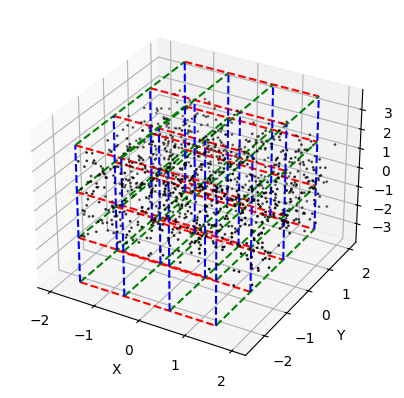

In [2]:
N_realisation =0
np.random.seed(N_realisation)
N0_particle = 10 ** 3

XP0 = np.random.uniform(-2, 2, N0_particle) 
YP0 = np.random.uniform(-2, 2, N0_particle)
ZP0 = np.random.uniform(-2, 2, N0_particle)

St0 = 0.25
R0 = 1
a, alpha, R, Fr, gravity = 1, 1, 1.99, 5, True

xl, xr = -2, 2
yl, yr = -3, 3
zd, zu = -4, 4

dx_col, dy_col, dz_col = 1, 1, 1
Nx_col, Ny_col, Nz_col = 4, 4, 4
gridA_xc, gridA_yc, gridA_zc = np.meshgrid(np.linspace(xl+dx_col/2, xr-dx_col/2, Nx_col), 
                                           np.linspace(yl+dy_col/2, yr-dy_col, Ny_col), 
                                           np.linspace(zd+dz_col/2, zu-dz_col/2, Nz_col), indexing='ij')
gridB_xc, gridB_yc, gridB_zc = np.meshgrid(np.linspace(xl, xr, Nx_col+1), np.linspace(yl, yr, Ny_col+1), np.linspace(zd, zu, Nz_col+1), indexing='ij')

# Plot grid lines
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot lines along x-axis
for i in range(Ny_col):
    for j in range(Nz_col):
        ax.plot(gridA_xc[:, i, j], gridA_yc[:, i, j], gridA_zc[:, i, j], color='r',linestyle='--')

# Plot lines along y-axis
for i in range(Nx_col):
    for j in range(Nz_col):
        ax.plot(gridA_xc[i, :, j], gridA_yc[i, :, j], gridA_zc[i, :, j], color='g',linestyle='--')


# Plot lines along z-axis
for i in range(Nx_col):
    for j in range(Ny_col):
        ax.plot(gridA_xc[i, j, :], gridA_yc[i, j, :], gridA_zc[i, j, :], color='b',linestyle='--')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(XP0, YP0, ZP0,s=1, c='k', marker='o')


plt.show()

In [3]:
X, Y, Z = np.meshgrid(np.linspace(-2, 2, 101), np.linspace(-2, 2, 100), np.linspace(-2, 2, 101), indexing='ij')
if Y.any() == 0:
    raise ValueError('Y cannot be zero')
PHI = np.arctan(Z/Y)
dist = np.sqrt(X**2 + Y**2 + Z**2)
r_planar = np.sqrt(Z**2 + Y**2)

mask = dist > R0

Ux = -(2 * (r_planar)**2 + X**2 -1) / 5
Ux[mask] = (-(a**5)/15) * (2/(a**3) + (r_planar[mask]**2 - 2*(X[mask]**2))/(dist[mask]**5))

Ur = X * r_planar / 5
Ur[mask] = (a**5) * X[mask] * r_planar[mask] / (5 * dist[mask]**5)

Uy = Ur * Y / r_planar
Uz = Ur * Z / r_planar

# a simple test to verify result
# test = Uy[:, :, 50]
# plt.contourf(X[:, :, 50], Y[:, :, 50], test, 50)
# plt.colorbar()

# # Plot velocity field
# ax = plt.figure().add_subplot(projection='3d')
# ax.quiver(X, Y, Z, Ux, Uy, Uz, length=0.2, normalize=True)


# plt.show()

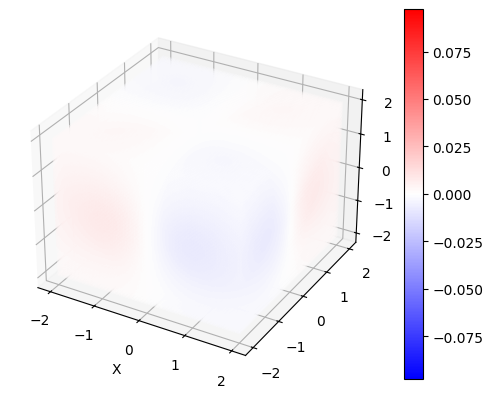

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(X, Y, Z, c=Uy, s=0.1,  cmap='bwr')
fig.colorbar(img)
plt.xlabel('X')
plt.show()

In [5]:
def solve_ivp_active_3d(args):


        q0, t_span = args

        # gravity = True
        positive_time = True

        def active_tracer_traj(t, Z) :
                # state-space vector 
                # Z[0] : xp, Z[1] : yp, Z[2] : zp
                # Z[3] : vx, Z[4] : vy, Z[5] : vz
                # compute flow field at particle position (xp, yp, zp)
                xp = Z[0]
                yp = Z[1]
                zp = Z[2]
                dist = np.sqrt(xp**2 + yp**2+ zp**2)

                if dist <= a:
                        Ux = alpha * (a**2 - dist**2 - yp**2) / 5
                        Uy = alpha * xp * yp / 5
                        dUxdt = 0
                        dUydt = 0
                        dUxdx = -2 * alpha * xp / 5
                        dUxdy = -4 * alpha * yp / 5
                        dUydx = alpha * yp / 5
                        dUydy = alpha * xp / 5


                else :
                        Ux = (-alpha*(a**5)/15) * (2/(a**3) + (yp**2 - 2*(xp**2))
                                         /(dist**5))
                        Uy = alpha* a**5 * yp * xp/ ( 5*(dist ** 5))
                        dUxdt = 0
                        dUydt = 0

                        dUxdx = (-alpha*(a**5)/15) * (6 * (xp ** 3) - 9 * (xp * (yp ** 2)))/(dist**7)
                        dUxdy = (-alpha*(a**5)/15) * (-3 * (yp ** 3) + 12 * (yp * (xp ** 2)))/(dist**7)
                        dUydx = (alpha * (a**5)/5) * ((yp ** 3) - 4 * (yp * (xp ** 2))) / (dist**7)
                        dUydy = (alpha * (a**5)/5) * ((xp ** 3) - 4 * (xp * (yp ** 2))) / (dist**7)



                # define derivatives
                dxpdt = Z[2]  # vx
                dypdt = Z[3]  # vy
                ddxpdtt = R*(Ux - dxpdt)/St + (3*R/2) * (dUxdt + Ux*dUxdx + Uy*dUxdy)
                ddypdtt = R*(Uy - dypdt)/St + (3*R/2) * (dUydt + Ux*dUydx + Uy*dUydy)  - gravity * (1-3*R/2) / (Fr**2)

                if positive_time:
                        return [dxpdt, dypdt, ddxpdtt, ddypdtt]
                else:
                        return [-dxpdt, -dypdt, -ddxpdtt, -ddypdtt]


        x0, y0, vx0, vy0, St = q0
        sol = sp.integrate.solve_ivp(active_tracer_traj, [t_span[0], t_span[-1]], [x0, y0, vx0, vy0], t_eval=t_span, vectorized=True)
        xpt, ypt, vxt, vyt = sol.y[0][-1], sol.y[1][-1], sol.y[2][-1], sol.y[3][-1]
        #   t_eval = sol.t

        # return xpt, ypt, vxt, vyt
        return sol.y[0], sol.y[1], sol.y[2], sol.y[3]
